In [3]:
import datetime as dt
import matplotlib.pyplot as plt
from matplotlib import style
import pandas as pd
import pandas_datareader.data as web

import numpy as np
from scipy.stats import norm
from scipy.stats import t

In [4]:
style.use('ggplot')

start = dt.datetime(2015, 1, 1)
end = dt.datetime.now()

In [18]:
df = web.DataReader("TSLA", 'yahoo', start, end)
df.dropna()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2015-01-02,44.650002,42.652000,44.574001,43.862000,23822000.0,43.862000
2015-01-05,43.299999,41.431999,42.910000,42.018002,26842500.0,42.018002
2015-01-06,42.840000,40.841999,42.012001,42.256001,31309500.0,42.256001
2015-01-07,42.956001,41.956001,42.669998,42.189999,14842000.0,42.189999
2015-01-08,42.759998,42.001999,42.562000,42.124001,17212500.0,42.124001
...,...,...,...,...,...,...
2022-04-05,1152.869995,1087.300049,1136.300049,1091.260010,26691700.0,1091.260010
2022-04-06,1079.000000,1027.699951,1073.469971,1045.760010,29782800.0,1045.760010
2022-04-07,1076.589966,1021.539978,1052.390015,1057.260010,26482400.0,1057.260010


In [6]:
returns = (df['Close']/df['Close'].shift(1))-1
# Take the array from 2nd (element 1) to end and divide it by the array less the last element
# Basically tom - today for each element
returns = returns.dropna().values

In [7]:
mu_norm, sig_norm = norm.fit(returns) # extract the mean and sigma of the closest normal distribution fit
print("Normal mean is {0:.8f}, sigma is {1:.8f}".format(mu_norm, sig_norm))
dx = 0.0001 # resolution of the distribution
x = np.arange(-1, 1, dx)
pdf_n = norm.pdf(x, mu_norm, sig_norm)

Normal mean is 0.00101731, sigma is 0.01691382


In [8]:
nu, mu_t, sig_t = t.fit(returns)
nu = np.round(nu)
print("Student T mean is {0:.8f}, sigma is {1:.8f}, nu is {2}".format(mu_t, sig_t, nu))
pdf_t = t.pdf(x, nu, mu_t, sig_t)

Student T mean is 0.00130696, sigma is 0.01025185, nu is 3.0


In [12]:
h = 1
alpha = 0.05
xanu = t.ppf(alpha, nu)

CVaR_n = alpha**-1 * norm.pdf(norm.ppf(alpha))*sig_norm - mu_norm
VaR_n = norm.ppf(1-alpha)*sig_norm - mu_norm

In [13]:

VaR_t = np.sqrt((nu-2)/nu) * t.ppf(1-alpha, nu)*sig_norm  - h*mu_norm

CVaR_t = -1/alpha * (1-nu)**(-1) * (nu-2+xanu**2) * t.pdf(xanu, nu)*sig_norm  - h*mu_norm

In [14]:
print("The 99% VaR (Normal) is {0:.2f}%".format(VaR_n*100))
print("The 99% CVaR (Normal) is {0:.2f}%".format(CVaR_n*100))
print("The 99% VaR (Student-t) is {0:.2f}%".format(VaR_t*100))
print("The 99% CVaR (Student-t) is {0:.2f}%".format(CVaR_t*100))

The 99% VaR (Normal) is 2.68%
The 99% CVaR (Normal) is 3.39%
The 99% VaR (Student-t) is 2.20%
The 99% CVaR (Student-t) is 4.92%


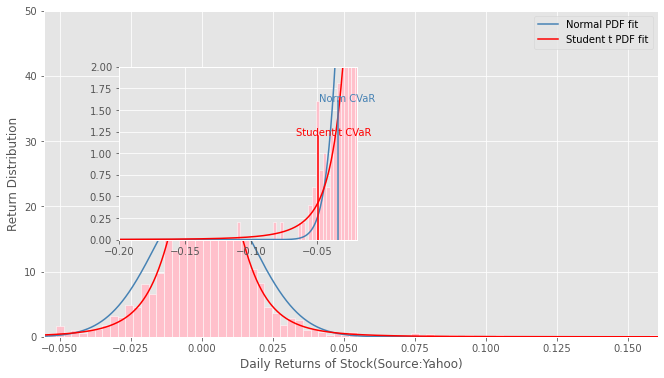

In [15]:
import seaborn as sns
plt.figure(num=1, figsize=(11, 6))
# main figure
plt.hist(returns, bins=100, density=True, color='pink', edgecolor='white')
plt.axis("tight")
plt.plot(x, pdf_n, 'steelblue', label="Normal PDF fit")
plt.axis("tight")
plt.plot(x, pdf_t, 'red', label="Student t PDF fit")
plt.xlim([min(returns)/2, max(returns)])
plt.ylim([0, 50])
plt.legend(loc="best")
plt.xlabel("Daily Returns of Stock(Source:Yahoo)")
plt.ylabel("Return Distribution")
# inset
a = plt.axes([.22, .35, .3, .4])
plt.hist(returns, bins=100, density=True, color='pink', edgecolor='white')
plt.plot(x, pdf_n, 'steelblue')
plt.plot(x, pdf_t, 'red')
# Student VaR line
plt.plot([-CVaR_t, -CVaR_t], [0, 1.2], c='red')
# Normal VaR line
plt.plot([-CVaR_n, -CVaR_n], [0, 1.6], c='steelblue')
plt.text(-CVaR_n-0.015, 1.6, "Norm CVaR", color='steelblue')
plt.text(-CVaR_t-0.0171, 1.2, "Student t CVaR", color='red')
plt.xlim([-0.2, -0.02])
plt.ylim([0, 2])
plt.show()